In [1]:
# https://xilinx.github.io/brevitas/getting_started.html
# works with automated folding.

from torch.nn import Module
import torch.nn.functional as F

import brevitas.nn as qnn
from brevitas.quant import Int8Bias as BiasQuant

import os
import onnx
import torch
import numpy as np
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, Dataset
from brevitas.nn import QuantLinear, QuantReLU
import torch.nn as nn
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange

weight_bit_width = 4
act_bit_width = 4

torch.manual_seed(0)

# class QuantWeightActLeNet(Module):
#     def __init__(self):
#         super(QuantWeightActLeNet, self).__init__()
#         self.quant_inp = qnn.QuantIdentity(bit_width=4)
#         self.conv1 = qnn.QuantConv2d(3, 16, 5, bias=True, weight_bit_width=weight_bit_width)
#         self.relu1 = qnn.QuantReLU(bit_width=act_bit_width)
#         self.conv2 = qnn.QuantConv2d(16, 16, 5, bias=True, weight_bit_width=weight_bit_width)
#         self.relu2 = qnn.QuantReLU(bit_width=act_bit_width)
#         self.flatten = nn.Flatten()
#         self.fc1   = qnn.QuantLinear(16*10*10, 120, bias=True, weight_bit_width=weight_bit_width)
#         self.relu3 = qnn.QuantReLU(bit_width=act_bit_width)
#         self.fc2   = qnn.QuantLinear(120, 84, bias=True, weight_bit_width=weight_bit_width)
#         self.relu4 = qnn.QuantReLU(bit_width=act_bit_width)
#         self.fc3   = qnn.QuantLinear(84, 10, bias=False)

#     def forward(self, x):
#         out = self.quant_inp(x)
#         out = self.relu1(self.conv1(out))
#         out = F.max_pool2d(out, 2)
#         out = self.relu2(self.conv2(out))
#         # out = F.max_pool2d(out, 2)
#         # out = self.quant_inp(out)
#         # out = out.reshape(out.shape[0], -1)
#         out = self.flatten(out)
#         # out = self.quant_inp(out)
#         out = self.relu3(self.fc1(out))
#         out = self.relu4(self.fc2(out))
#         out = self.fc3(out)
#         return out


class QuantWeightActLeNet(Module):
    def __init__(self):
        super(QuantWeightActLeNet, self).__init__()
        self.quant_inp = qnn.QuantIdentity(bit_width=4)
        self.conv1 = qnn.QuantConv2d(3, 16, 5, bias=True, weight_bit_width=weight_bit_width)
        self.relu1 = qnn.QuantReLU(bit_width=act_bit_width)
        # self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = qnn.QuantConv2d(16, 16, 5, bias=True, weight_bit_width=weight_bit_width)
        self.relu2 = qnn.QuantReLU(bit_width=act_bit_width)
        self.flatten = nn.Flatten()
        self.fc1   = qnn.QuantLinear(16*10*10, 120, bias=True, weight_bit_width=weight_bit_width)
        self.bn1 = nn.BatchNorm1d(120)
        self.do1 = nn.Dropout(0.5)
        self.fc2   = qnn.QuantLinear(120, 84, bias=True, weight_bit_width=weight_bit_width)
        self.bn2 = nn.BatchNorm1d(84)
        self.do2 = nn.Dropout(0.5)
        self.fc3   = qnn.QuantLinear(84, 10, bias=False)

    def forward(self, x):
        out = self.quant_inp(x)
        out = self.conv1(out)
        out = self.relu1(out)
        out = F.max_pool2d(out, 2)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.bn1(out)
        # out = self.do1(out)
        out = self.fc2(out)
        out = self.bn2(out)
        # out = self.do2(out)
        out = self.fc3(out)
        return out


    # def forward(self, x):
    #     out = self.quant_inp(x)
    #     out = self.relu1(self.conv1(out))
    #     print(f"Shape after conv1: {out.shape}")
    #     out = F.max_pool2d(out, 2)
    #     out = self.relu2(self.conv2(out))
    #     print(f"Shape after conv2: {out.shape}")
    #     # out = F.max_pool2d(out, 2)
    #     out = self.quant_inp(out)
    #     # out = out.reshape(out.shape[0], -1)
    #     out = self.flatten(out)
    #     print(f"Shape after flattening: {out.shape}")
    #     out = self.relu3(self.fc1(out))
    #     print(f"Shape after fc1: {out.shape}")
    #     out = self.relu4(self.fc2(out))
    #     print(f"Shape after fc2: {out.shape}")
    #     out = self.fc3(out)
    #     return out

model = QuantWeightActLeNet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Target device: " + str(device))

model.to(device); # The semicolon is for not printing the model.


Target device: cpu


In [32]:
input_tensor = torch.randn(2, 3, 32, 32)
output = model(input_tensor)

### Data processing

In [2]:
# This is for 4-bit quantization. The quantization value can be changed in line 11. 

import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os

quant_param = 16 # log2(quant_param) bits. #256 means no quanization, 2 means 1-bit quantization

def quantize_image(image):
    """Quantize and binarize an image."""
    image = image.astype(np.float32)
    image = np.floor(image / (256/quant_param))  # Example: reducing to 4-bit quantization
    return image.astype(np.float32)

def save_dataset_as_npz(data, labels, filename):
    """Save the dataset as a .npz file."""
    np.savez_compressed(filename, data=data, labels=labels)

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Quantize the images
train_images = np.array([quantize_image(image.numpy().transpose(1, 2, 0) * 255) for image, _ in train_dataset])
train_labels = np.array(train_dataset.targets)

test_images = np.array([quantize_image(image.numpy().transpose(1, 2, 0) * 255) for image, _ in test_dataset])
test_labels = np.array(test_dataset.targets)

# Save the datasets
os.makedirs('./quantized_data', exist_ok=True)
save_dataset_as_npz(train_images, train_labels, './quantized_data/cifar10_train.npz')
save_dataset_as_npz(test_images, test_labels, './quantized_data/cifar10_test.npz')

print('Saved the dataset as .npz files')


class CIFAR10QuantizedDataset(Dataset):
    def __init__(self, npz_file):
        data = np.load(npz_file)
        self.images = data['data']
        self.labels = data['labels']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32) / 255.0
        label = self.labels[idx]
        image = torch.tensor(image.transpose(2, 0, 1))  # HWC to CHW format
        label = torch.tensor(label, dtype=torch.long)
        return image, label

# Load the quantized dataset
train_dataset = CIFAR10QuantizedDataset('./quantized_data/cifar10_train.npz')
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = CIFAR10QuantizedDataset('./quantized_data/cifar10_test.npz')
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified
Saved the dataset as .npz files


### Training and testing

In [3]:
import torch.optim as optim

def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):        
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()   
                
        # forward pass
        output = model(images.float())
        # loss = criterion(output, labels.unsqueeze(1))
        loss = criterion(output, labels)
        
        # backward pass + run optimizer to update weights
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.data.cpu().numpy()) 
    return losses


def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            output = model(images.float())
            # run the output through sigmoid
            # output = torch.sigmoid(output_orig)  
            # compare against a threshold of 0.5 to generate 0/1
            # pred = (output.detach().cpu().numpy() > 0.5) * 1
            _, pred = torch.max(output.data, 1)
            labels = labels.cpu().float()
            y_true.extend(labels.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
            # y_pred.extend((pred == labels).sum().item())
        
    return accuracy_score(y_true, y_pred)

num_epochs = 10
lr = 0.001 

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# loss criterion and optimizer
# criterion = nn.BCEWithLogitsLoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

running_loss = []
running_test_acc = []
t = trange(num_epochs, desc="Training loss", leave=True)

for epoch in t:
        loss_epoch = train(model, train_loader, optimizer,criterion)
        test_acc = test(model, test_loader)
        t.set_description("Training loss = %f test accuracy = %f" % (np.mean(loss_epoch), test_acc))
        t.refresh() # to show immediately the update           
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)


Training loss:   0%|                                                              | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1255: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1758.)
  return super(Tensor, self).rename(names)
Training loss = 1.269577 test accuracy = 0.535300: 100%|█████████████████| 10/10 [01:36<00:00,  9.70s/it]


In [4]:
test_accuracy = test(model, test_loader)
print('test accuracy = ', test_accuracy)

test accuracy =  0.5353


In [126]:
# # Save the Brevitas model to disk
# torch.save(model.state_dict(), "state_dict_LeNet_WeightAct.pth")
# # torch.save(model, "LeNet_WeightAct.pth")

####  Convert to ONNX model

In [5]:
import torch
import onnx
from finn.util.test import get_test_model_trained
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
from qonnx.core.modelwrapper import ModelWrapper
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.fold_constants import FoldConstants
from qonnx.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs

# # cnv = get_test_model_trained("CNV", 1, 1)
# model_path = "state_dict_LeNet_WeightAct.pth"
# state_dict = torch.load(model_path)  # This returns an OrderedDict
# model.load_state_dict(state_dict)  # Load the state dict into the model
# # model = torch.load(model_path)

export_onnx_path = "LeNet_WeightAct.onnx"
# export_qonnx(model, torch.randn(1, 3, 32, 32), export_onnx_path)
export_qonnx(model, torch.randn(1, 3, 32, 32), export_onnx_path, opset_version=9) # opset_version=9 is added as ONNX version 14 is not supported.
qonnx_cleanup(export_onnx_path, out_file=export_onnx_path)

model = ModelWrapper(export_onnx_path)
model = model.transform(ConvertQONNXtoFINN())
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(RemoveStaticGraphInputs())
model.save("LeNet_WeightAct_tidy.onnx")

In [37]:
from finn.util.visualization import showInNetron
showInNetron("LeNet_WeightAct_tidy.onnx")

Stopping http://0.0.0.0:8081
Serving 'LeNet_WeightAct_tidy.onnx' at http://0.0.0.0:8081


### Adding pre and post processing

In [6]:
from finn.util.pytorch import ToTensor
from qonnx.transformation.merge_onnx_models import MergeONNXModels
from qonnx.core.datatype import DataType

model = ModelWrapper("LeNet_WeightAct_tidy.onnx")
global_inp_name = model.graph.input[0].name
ishape = model.get_tensor_shape(global_inp_name)
# print('ishape = ', ishape)

# preprocessing: torchvision's ToTensor divides uint8 inputs by 255
totensor_pyt = ToTensor()
chkpt_preproc_name = "LeNet_WeightAct_tidy_preproc.onnx"
export_qonnx(totensor_pyt, torch.randn(ishape), chkpt_preproc_name, opset_version=9)
qonnx_cleanup(chkpt_preproc_name, out_file=chkpt_preproc_name)
pre_model = ModelWrapper(chkpt_preproc_name)
pre_model = pre_model.transform(ConvertQONNXtoFINN())

# join preprocessing and core model
model = model.transform(MergeONNXModels(pre_model))

# add input quantization annotation: UINT8 for all BNN-PYNQ models
global_inp_name = model.graph.input[0].name
model.set_tensor_datatype(global_inp_name, DataType["UINT8"])

/home/inets/arish/FINN_arish/finn/deps/qonnx/src/qonnx/transformation/infer_data_layouts.py:127: UserWarning: Assuming 4D input is NCHW
  warnings.warn("Assuming 4D input is NCHW")


In [7]:
from qonnx.transformation.insert_topk import InsertTopK
from qonnx.transformation.infer_datatypes import InferDataTypes

# postprocessing: insert Top-1 node at the end
model = model.transform(InsertTopK(k=1))
chkpt_name = "LeNet_WeightAct_tidy_prepost.onnx"
# tidy-up again
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())
model.save(chkpt_name)

In [40]:
from finn.util.visualization import showInNetron
showInNetron("LeNet_WeightAct_tidy_prepost.onnx")

Stopping http://0.0.0.0:8081
Serving 'LeNet_WeightAct_tidy_prepost.onnx' at http://0.0.0.0:8081


### Streamline

In [8]:
from finn.transformation.streamline import Streamline
from qonnx.transformation.lower_convs_to_matmul import LowerConvsToMatMul
from qonnx.transformation.bipolar_to_xnor import ConvertBipolarMatMulToXnorPopcount
import finn.transformation.streamline.absorb as absorb
from finn.transformation.streamline.reorder import MakeMaxPoolNHWC, MoveScalarLinearPastInvariants
from qonnx.transformation.infer_data_layouts import InferDataLayouts
from qonnx.transformation.general import RemoveUnusedTensors
import finn.transformation.fpgadataflow.convert_to_hw_layers as to_hw
from qonnx.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
from finn.transformation.streamline.round_thresholds import RoundAndClipThresholds

from qonnx.transformation.batchnorm_to_affine import BatchNormToAffine

model = ModelWrapper("LeNet_WeightAct_tidy_prepost.onnx")

model = model.transform(MoveScalarLinearPastInvariants())
model = model.transform(Streamline())
model = model.transform(LowerConvsToMatMul())
model = model.transform(MakeMaxPoolNHWC())
model = model.transform(absorb.AbsorbTransposeIntoMultiThreshold())
model = model.transform(ConvertBipolarMatMulToXnorPopcount())
model = model.transform(Streamline())

# absorb final add-mul nodes into TopK
model = model.transform(absorb.AbsorbScalarMulAddIntoTopK())

# bit of tidy-up
model = model.transform(InferDataLayouts())
model = model.transform(RemoveUnusedTensors())
model.save("LeNet_WeightAct_tidy_streamlined.onnx")

In [42]:
from finn.util.visualization import showInNetron
showInNetron("LeNet_WeightAct_tidy_streamlined.onnx")

Stopping http://0.0.0.0:8081
Serving 'LeNet_WeightAct_tidy_streamlined.onnx' at http://0.0.0.0:8081


### Partitioning, coversion of HW layers and folding

In [34]:
# thresh_node = model.get_nodes_by_op_type("Thresholding")[0]
# thresh_node_inst = getCustomOp(thresh_node)
# thresh_node_inst.set_nodeattr("preferred_impl_style", "hls")

In [3]:
# # print the names of the supported PYNQ boards
# from finn.util.basic import pynq_part_map
# print(pynq_part_map.keys())

In [9]:
from finn.util.basic import pynq_part_map
# change this if you have a different PYNQ board, see list above
pynq_board = "Pynq-Z1"
fpga_part = pynq_part_map[pynq_board]
target_clk_ns = 10

import finn.transformation.fpgadataflow.convert_to_hw_layers as to_hw
from finn.transformation.fpgadataflow.create_dataflow_partition import (
    CreateDataflowPartition,
)
from finn.transformation.move_reshape import RemoveCNVtoFCFlatten
from finn.transformation.fpgadataflow.specialize_layers import SpecializeLayers
from qonnx.custom_op.registry import getCustomOp
from qonnx.transformation.infer_data_layouts import InferDataLayouts

model = ModelWrapper("LeNet_WeightAct_tidy_streamlined.onnx")
model = model.transform(to_hw.InferBinaryMatrixVectorActivation())
model = model.transform(to_hw.InferQuantizedMatrixVectorActivation())

# TopK to LabelSelect
model = model.transform(to_hw.InferLabelSelectLayer())

# input quantization (if any) to standalone thresholding
model = model.transform(to_hw.InferThresholdingLayer())
model = model.transform(to_hw.InferConvInpGen())
model = model.transform(to_hw.InferStreamingMaxPool())

# get rid of Reshape(-1, 1) operation between hw nodes
model = model.transform(RemoveCNVtoFCFlatten())

# get rid of Tranpose -> Tranpose identity seq
model = model.transform(absorb.AbsorbConsecutiveTransposes())

# infer tensor data layouts
model = model.transform(InferDataLayouts())

parent_model = model.transform(CreateDataflowPartition())
parent_model.save("LeNet_WeightAct_tidy_dataflow_parent.onnx")
sdp_node = parent_model.get_nodes_by_op_type("StreamingDataflowPartition")[0]
sdp_node = getCustomOp(sdp_node)
dataflow_model_filename = sdp_node.get_nodeattr("model")

# save the dataflow partition with a different name for easier access
# and specialize the layers to HLS variants
dataflow_model = ModelWrapper(dataflow_model_filename)
dataflow_model = dataflow_model.transform(SpecializeLayers(fpga_part))
dataflow_model.save("LeNet_WeightAct_dataflow_model.onnx")

In [44]:
showInNetron("LeNet_WeightAct_tidy_dataflow_parent.onnx")

Stopping http://0.0.0.0:8081
Serving 'LeNet_WeightAct_tidy_dataflow_parent.onnx' at http://0.0.0.0:8081


In [27]:
showInNetron("LeNet_WeightAct_dataflow_model.onnx")

Stopping http://0.0.0.0:8081
Serving 'LeNet_WeightAct_dataflow_model.onnx' at http://0.0.0.0:8081


In [14]:
# from functools import partial
# from finn.analysis.fpgadataflow.exp_cycles_per_layer import exp_cycles_per_layer
# from finn.analysis.fpgadataflow.res_estimation import res_estimation
# model = ModelWrapper("LeNet_WeightAct_dataflow_model.onnx")
# cycles_dict = model.analysis(exp_cycles_per_layer)
# cycles_dict

### Folding

In [10]:
from finn.transformation.fpgadataflow.make_zynq_proj import ZynqBuild
model = ModelWrapper("LeNet_WeightAct_dataflow_model.onnx")
fc_layers = model.get_nodes_by_op_type("MVAU_hls")
# print(fc_layers)
# each tuple is (PE, SIMD, in_fifo_depth) for a layer
# Depends on input and output feature maps (IFM, OFM)
folding = [
    (16, 3, [32]),   # conv1
    (16, 16, [32]),   # conv2
    (10, 80, [64]), # fc1
    (12, 10, [64]), # fc2  (HLS 3)
    (1, 6, [10]),   #fc3
]

# Apply folding parameters to fully connected layers
for fcl, (pe, simd, ififodepth) in zip(fc_layers, folding):
    fcl_inst = getCustomOp(fcl)
    fcl_inst.set_nodeattr("PE", pe)
    fcl_inst.set_nodeattr("SIMD", simd)
    fcl_inst.set_nodeattr("inFIFODepths", ififodepth)
    # Debug: Verify parameters are set correctly
    print(f"{fcl.name} -> PE: {pe}, SIMD: {simd}, inFIFOdepths: {ififodepth}")

# use same SIMD values for the sliding window operators
swg_layers = model.get_nodes_by_op_type("ConvolutionInputGenerator_rtl")
# for i in range(len(swg_layers)):
#     swg_inst = getCustomOp(swg_layers[i])
#     simd = folding[i][1]
#     swg_inst.set_nodeattr("SIMD", simd)
#     print(f"{swg.name} -> SIMD: {simd}")


for i, swg in enumerate(swg_layers):
  if i < len(folding):
      swg_inst = getCustomOp(swg)
      simd = folding[i][1]
      swg_inst.set_nodeattr("SIMD", simd)
      # Debug: Verify SIMD is set correctly
      print(f"{swg.name} -> SIMD: {simd}")
  else:
      print(f"No folding parameters available for {swg.name}")

# set parallelism for input quantizer to be same as first layer's SIMD
inp_qnt_node = model.get_nodes_by_op_type("Thresholding_rtl")[0]
inp_qnt = getCustomOp(inp_qnt_node)
inp_qnt.set_nodeattr("PE", 1)
      
# Save the transformed model
model = model.transform(GiveUniqueNodeNames())
model.save("LeNet_WeightAct_folded.onnx")
  
# Debug: Print the shapes to ensure compatibility
for node in model.graph.node:
  node_inst = getCustomOp(node)
  try:
      print(f"Checking folded input shape for node: {node.name}")
      folded_shape = node_inst.get_folded_input_shape()
      print(f"{node.name}: Folded input shape = {folded_shape}")
  except Exception as e:
      print(f"Error getting folded input shape for {node.name}: {e}")

# # Hardware generation parameters
# test_pynq_board = "Pynq-Z1"
# target_clk_ns = 10

# # Transform and verify if parameters are applied
# try:
#   model = model.transform(ZynqBuild(platform=test_pynq_board, period_ns=target_clk_ns))
#   print("Hardware generation successful")
# except Exception as e:
#   print(f"Error during hardware generation: {e}")

 -> PE: 16, SIMD: 3, inFIFOdepths: [32]
 -> PE: 16, SIMD: 16, inFIFOdepths: [32]
 -> SIMD: 3
 -> SIMD: 16
Checking folded input shape for node: Thresholding_rtl_0
Thresholding_rtl_0: Folded input shape = (1, 32, 32, 3, 1)
Checking folded input shape for node: ConvolutionInputGenerator_rtl_0
ConvolutionInputGenerator_rtl_0: Folded input shape = (1, 32, 32, 1, 3)
Checking folded input shape for node: MVAU_hls_0
MVAU_hls_0: Folded input shape = (1, 28, 28, 25, 3)
Checking folded input shape for node: StreamingMaxPool_hls_0
StreamingMaxPool_hls_0: Folded input shape = (1, 28, 28, 1, 16)
Checking folded input shape for node: ConvolutionInputGenerator_rtl_1
ConvolutionInputGenerator_rtl_1: Folded input shape = (1, 14, 14, 1, 16)
Checking folded input shape for node: MVAU_hls_1
MVAU_hls_1: Folded input shape = (1, 10, 10, 25, 16)
Checking folded input shape for node: MVAU_rtl_0
MVAU_rtl_0: Folded input shape = (1, 1600, 1)


In [113]:
showInNetron("LeNet_WeightAct_folded.onnx")

Stopping http://0.0.0.0:8081
Serving 'LeNet_WeightAct_folded.onnx' at http://0.0.0.0:8081


In [11]:
from functools import partial
from finn.analysis.fpgadataflow.exp_cycles_per_layer import exp_cycles_per_layer
from finn.analysis.fpgadataflow.res_estimation import res_estimation
model = ModelWrapper("LeNet_WeightAct_folded.onnx")
cycles_dict = model.analysis(exp_cycles_per_layer)
cycles_dict

/home/inets/arish/FINN_arish/finn/src/finn/custom_op/fpgadataflow/streamingmaxpool.py:139: UserWarning: Estimated latency for layer StreamingMaxPool_hls_0 can be lower than
             actual latency!
  warnings.warn(


{'Thresholding_rtl_0': 3072,
 'ConvolutionInputGenerator_rtl_0': 19733,
 'MVAU_hls_0': 19600,
 'StreamingMaxPool_hls_0': 980,
 'ConvolutionInputGenerator_rtl_1': 2561,
 'MVAU_hls_1': 2500,
 'MVAU_rtl_0': 192000}

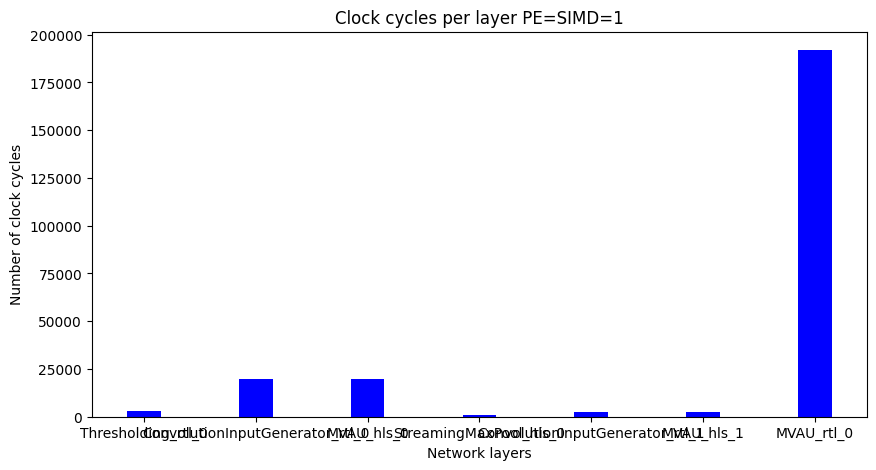

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5))
plt.bar(cycles_dict.keys(), cycles_dict.values(), color ='blue', width = 0.3)
plt.xlabel("Network layers")
plt.ylabel("Number of clock cycles")
plt.title("Clock cycles per layer PE=SIMD=1")
plt.show()

In [16]:
res_dict = model.analysis(partial(res_estimation, fpgapart="xc7z020clg400-1"))
res_dict

{'Thresholding_rtl_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 32,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_rtl_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 348,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MVAU_hls_0': {'BRAM_18K': 6,
  'BRAM_efficiency': 0.043402777777777776,
  'LUT': 2517,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'StreamingMaxPool_hls_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_rtl_1': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 428,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MVAU_hls_1': {'BRAM_18K': 29,
  'BRAM_efficiency': 0.04789272030651341,
  'LUT': 11722,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MVAU_rtl_0': {'BRAM_18K': 47,
  'BRAM_efficiency': 0.8865248226950354,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 1}}

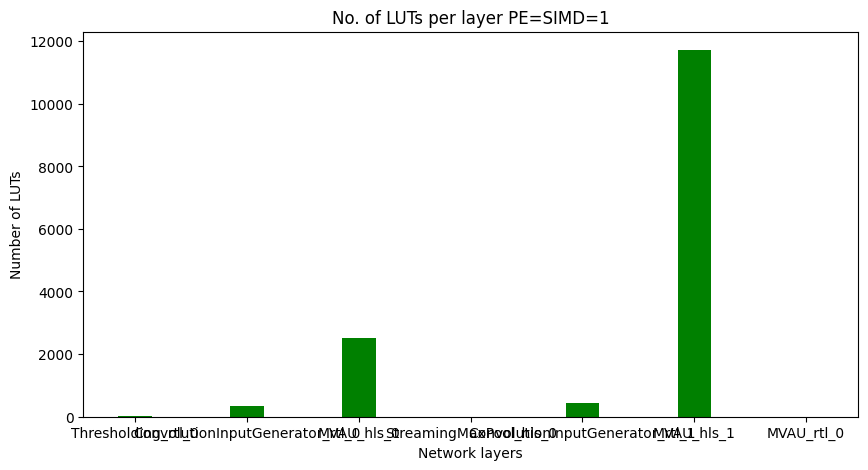

In [17]:
# Extracting LUTs from res_dict
LUTs = [res_dict[key]["LUT"] for key in res_dict.keys()]   

#Plotting the bar graph of each network layer with their corresponding LUT resource utilization
fig = plt.figure(figsize = (10, 5))
plt.bar(res_dict.keys(), LUTs, color ='green', width = 0.3)
plt.xlabel("Network layers")
plt.ylabel("Number of LUTs")
plt.title("No. of LUTs per layer PE=SIMD=1")
plt.show()

In [88]:
# from qonnx.custom_op.registry import getCustomOp

# list_of_mvaus = model.get_nodes_by_op_type("MVAU_hls")
# mvau0 = list_of_mvaus[0]

# mvau0_inst = getCustomOp(mvau0)

# # Get the node attributes to check the current setting
# print("The parallelization parameters of %s were: " % mvau0.name)
# print("PE: " + str(mvau0_inst.get_nodeattr("PE")))
# print("SIMD: " + str(mvau0_inst.get_nodeattr("SIMD")))

# # Set the new node attributes
# mvau0_inst.set_nodeattr("PE", 16)
# mvau0_inst.set_nodeattr("SIMD", 3)

# # Get the node attributes to check the updated setting
# print("The parallelization parameters of %s are updated to: " % mvau0.name)
# print("PE: " + str(mvau0_inst.get_nodeattr("PE")))
# print("SIMD: " + str(mvau0_inst.get_nodeattr("SIMD")))

The parallelization parameters of MVAU_hls_0 were: 
PE: 16
SIMD: 3
The parallelization parameters of MVAU_hls_0 are updated to: 
PE: 16
SIMD: 3


In [89]:
# model.save("cybsec_PE_SIMD_modified.onnx")
# showInNetron("cybsec_PE_SIMD_modified.onnx")

Stopping http://0.0.0.0:8081
Serving 'cybsec_PE_SIMD_modified.onnx' at http://0.0.0.0:8081


In [90]:
cycles_dict_updated = model.analysis(exp_cycles_per_layer)
cycles_dict_updated

{'Thresholding_rtl_0': 3072,
 'ConvolutionInputGenerator_rtl_0': 19733,
 'MVAU_hls_0': 19600,
 'StreamingMaxPool_hls_0': 980,
 'ConvolutionInputGenerator_rtl_1': 2561,
 'MVAU_hls_1': 2500,
 'MVAU_hls_2': 240,
 'MVAU_hls_3': 84,
 'MVAU_rtl_0': 840,
 'LabelSelect_hls_0': 10}

In [100]:
# Original model
model_orig = ModelWrapper("LeNet_WeightAct_folded.onnx")
list_of_mvaus = model_orig.get_nodes_by_op_type("MVAU_hls")
print("In the original model (pe=simd=1): ")
for mvau in list_of_mvaus:
    mvau_inst = getCustomOp(mvau)
    print("Layer: " + mvau.name)
    print("Input shape: " + str(mvau_inst.get_folded_input_shape()))
    print("Output shape: " + str(mvau_inst.get_folded_output_shape()))

In the original model (pe=simd=1): 
Layer: MVAU_hls_0
Input shape: (1, 28, 28, 25, 3)
Output shape: (1, 28, 28, 1, 16)
Layer: MVAU_hls_1
Input shape: (1, 10, 10, 25, 16)
Output shape: (1, 10, 10, 1, 16)
Layer: MVAU_hls_2
Input shape: (1, 20, 80)
Output shape: (1, 12, 10)
Layer: MVAU_hls_3
Input shape: (1, 12, 10)
Output shape: (1, 7, 12)


In [99]:
from finn.transformation.fpgadataflow.make_zynq_proj import ZynqBuild
test_pynq_board = "Pynq-Z1"
target_clk_ns = 10
model = ModelWrapper("LeNet_WeightAct_folded.onnx")
# model = model.transform(ZynqBuild(platform = pynq_board, period_ns = target_clk_ns))
try:
  model = model.transform(ZynqBuild(platform=test_pynq_board, period_ns=target_clk_ns))
  print("Hardware generation successful")
except Exception as e:
  print(f"Error during hardware generation: {e}")

/home/inets/arish/FINN_arish_old/finn/src/finn/transformation/fpgadataflow/floorplan.py:107: UserWarning: 15 nodes have no entry in the provided floorplan, SLR was set to -1
  warnings.warn(


Error during hardware generation: cannot reshape array of size 1600 into shape (1,10,10,0,80)


## Understanding the Build Configuration: `DataflowBuildConfig` <a id="underst_build_conf"></a>

The build configuration is specified by an instance of `finn.builder.build_dataflow_config.DataflowBuildConfig`. The configuration is a Python [`dataclass`](https://docs.python.org/3/library/dataclasses.html) which can be serialized into or de-serialized from JSON files for persistence, although we'll just set it up in Python here.
There are many options in the configuration to customize different aspects of the build, we'll only cover a few of them in this notebook. You can read the details on all the config options on [the FINN API documentation](https://finn-dev.readthedocs.io/en/latest/source_code/finn.builder.html#finn.builder.build_dataflow_config.DataflowBuildConfig).

Let's go over some of the members of the `DataflowBuildConfig`:

### Output Products <a id="output_prod"></a>

The build can produce many different outputs, and some of them can take a long time (e.g. bitfile synthesis for a large network). When you first start working on generating a new accelerator and exploring the different performance options, you may not want to go all the way to a bitfile. Thus, in the beginning you may just select the estimate reports as the output products. Gradually, you can generate the output products from later stages until you are happy enough with the design to build the full accelerator integrated into a shell.

The output products are controlled by:

* `generate_outputs`: list of output products (of type [`finn.builder.build_dataflow_config.DataflowOutputType`](https://finn-dev.readthedocs.io/en/latest/source_code/finn.builder.html#finn.builder.build_dataflow_config.DataflowOutputType)) that will be generated by the build. Some available options are:
    - `ESTIMATE_REPORTS` : report expected resources and performance per layer and for the whole network without any synthesis
    - `STITCHED_IP` : create a stream-in stream-out IP design that can be integrated into other Vivado IPI or RTL designs
    - `RTLSIM_PERFORMANCE` : use PyVerilator to do a performance/latency test of the `STITCHED_IP` design
    - `OOC_SYNTH` : run out-of-context synthesis (just the accelerator itself, without any system surrounding it) on the `STITCHED_IP` design to get post-synthesis FPGA resources and achievable clock frequency
    - `BITFILE` : integrate the accelerator into a shell to produce a standalone bitfile
    - `PYNQ_DRIVER` : generate a PYNQ Python driver that can be used to launch the accelerator
    - `DEPLOYMENT_PACKAGE` : create a folder with the `BITFILE` and `PYNQ_DRIVER` outputs, ready to be copied to the target FPGA platform.
* `output_dir`: the directory where all the generated build outputs above will be written into.
* `steps`: list of predefined (or custom) build steps FINN will go through. Use `build_dataflow_config.estimate_only_dataflow_steps` to execute only the steps needed for estimation (without any synthesis), and the `build_dataflow_config.default_build_dataflow_steps` otherwise (which is the default value). You can find the list of default steps [here](https://finn.readthedocs.io/en/latest/source_code/finn.builder.html#finn.builder.build_dataflow_config.default_build_dataflow_steps) in the documentation.

### Configuring the Board and FPGA Part <a id="config_fpga"></a>

* `fpga_part`: Xilinx FPGA part to be used for synthesis, can be left unspecified to be inferred from `board` below, or specified explicitly for e.g. out-of-context synthesis.
* `board`: target Xilinx Zynq or Alveo board for generating accelerators integrated into a shell. See the `pynq_part_map` and `alveo_part_map` dicts in [this file](https://github.com/Xilinx/finn-base/blob/dev/src/finn/util/basic.py#L41) for a list of possible boards.
* `shell_flow_type`: the target [shell flow type](https://finn-dev.readthedocs.io/en/latest/source_code/finn.builder.html#finn.builder.build_dataflow_config.ShellFlowType), only needed for generating full bitfiles where the FINN design is integrated into a shell (so only needed if `BITFILE` is selected) 

### Configuring the Performance <a id="config_perf"></a>

You can configure the performance (and correspondingly, the FPGA resource footprint) of the generated dataflow accelerator in two ways:

1) (basic) Set a target performance and let the compiler figure out the per-node parallelization settings.

2) (advanced) Specify a separate .json as `folding_config_file` that lists the degree of parallelization (as well as other hardware options) for each layer.

This notebook only deals with the basic approach, for which you need to set up:

* `target_fps`: target inference performance in frames per second. Note that target may not be achievable due to specific layer constraints, or due to resource limitations of the FPGA. 
* `synth_clk_period_ns`: target clock frequency (in nanoseconds) for Vivado synthesis. e.g. `synth_clk_period_ns=5.0` will target a 200 MHz clock. Note that the target clock period may not be achievable depending on the FPGA part and design complexity.

## Launch a Build: Only Estimate Reports <a id="build_estimate_report"></a>

##### This is based on "cybersecurity/3-build-accelerator-with-finn.ipynb" notebook.

In [113]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

# model_dir = os.environ['FINN_ROOT'] + "/notebooks/end2end_example/cybersecurity"
# model_file = "LeNet_WeightAct_folded.onnx"
model_file = "LeNet_WeightAct_tidy.onnx"
# model_file = "LeNet_WeightAct.onnx"

estimates_output_dir = "output_estimates_only"

#Delete previous run results if exist
if os.path.exists(estimates_output_dir):
    shutil.rmtree(estimates_output_dir)
    print("Previous run results deleted!")


cfg_estimates = build.DataflowBuildConfig(
    output_dir          = estimates_output_dir,
    mvau_wwidth_max     = 80,
    target_fps          = 1000000,
    synth_clk_period_ns = 10.0,
    fpga_part           = "xc7z020clg400-1",
    steps               = build_cfg.estimate_only_dataflow_steps,
    generate_outputs=[
        build_cfg.DataflowOutputType.ESTIMATE_REPORTS,
    ]
)

Previous run results deleted!


In [114]:
%%time
build.build_dataflow_cfg(model_file, cfg_estimates)

Building dataflow accelerator from LeNet_WeightAct_tidy.onnx
Intermediate outputs will be generated in /tmp/finn_dev_inets
Final outputs will be generated in output_estimates_only
Build log is at output_estimates_only/build_dataflow.log
Running step: step_qonnx_to_finn [1/10]
Running step: step_tidy_up [2/10]
Running step: step_streamline [3/10]
Running step: step_convert_to_hw [4/10]
Running step: step_create_dataflow_partition [5/10]
Running step: step_specialize_layers [6/10]
Running step: step_target_fps_parallelization [7/10]
Running step: step_apply_folding_config [8/10]
Running step: step_minimize_bit_width [9/10]
Running step: step_generate_estimate_reports [10/10]
Completed successfully
CPU times: user 672 ms, sys: 7.56 ms, total: 680 ms
Wall time: 679 ms


0

In [115]:
import json
def read_json_dict(filename):
    with open(filename, "r") as f:
        ret = json.load(f)
    return ret

In [116]:
read_json_dict(estimates_output_dir + "/report/estimate_network_performance.json")

{'critical_path_cycles': 17887,
 'max_cycles': 3920,
 'max_cycles_node_name': 'MVAU_hls_0',
 'estimated_throughput_fps': 25510.20408163265,
 'estimated_latency_ns': 178870.0}

In [110]:
read_json_dict(estimates_output_dir + "/report/estimate_layer_cycles.json")

{'ConvolutionInputGenerator_rtl_0': 1026,
 'MVAU_hls_0': 3920,
 'StreamingMaxPool_hls_0': 980,
 'ConvolutionInputGenerator_rtl_1': 2561,
 'MVAU_hls_1': 2000,
 'MVAU_hls_2': 3200,
 'MVAU_hls_3': 3360,
 'MVAU_rtl_0': 840}

In [111]:
read_json_dict(estimates_output_dir + "/report/op_and_param_counts.json")

{'ConvolutionInputGenerator_rtl_0': {},
 'MVAU_hls_0': {'op_mac_4bx4b': 352800,
  'param_weight_4b': 450,
  'param_threshold_12b': 6},
 'StreamingMaxPool_hls_0': {},
 'ConvolutionInputGenerator_rtl_1': {},
 'MVAU_hls_1': {'op_mac_4bx4b': 240000,
  'param_weight_4b': 2400,
  'param_threshold_13b': 16},
 'MVAU_hls_2': {'op_mac_4bx4b': 192000,
  'param_weight_4b': 192000,
  'param_threshold_15b': 120},
 'MVAU_hls_3': {'op_mac_4bx4b': 10080,
  'param_weight_4b': 10080,
  'param_threshold_13b': 84},
 'MVAU_rtl_0': {'op_mac_4bx8b': 840, 'param_weight_8b': 840},
 'total': {'op_mac_4bx4b': 794880.0,
  'param_weight_4b': 204930.0,
  'param_threshold_12b': 6.0,
  'param_threshold_13b': 100.0,
  'param_threshold_15b': 120.0,
  'op_mac_4bx8b': 840.0,
  'param_weight_8b': 840.0}}

In [112]:
read_json_dict(estimates_output_dir + "/report/estimate_layer_resources.json")

{'ConvolutionInputGenerator_rtl_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 348,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MVAU_hls_0': {'BRAM_18K': 10,
  'BRAM_efficiency': 0.009765625,
  'LUT': 4286,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'StreamingMaxPool_hls_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_rtl_1': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 348,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MVAU_hls_1': {'BRAM_18K': 14,
  'BRAM_efficiency': 0.03720238095238095,
  'LUT': 5624,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MVAU_hls_2': {'BRAM_18K': 56,
  'BRAM_efficiency': 0.7440476190476191,
  'LUT': 2963,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MVAU_hls_3': {'BRAM_18K': 4,
  'BRAM_efficiency': 0.546875,
  'LUT': 437,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MVAU_rtl_0': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.364

In [34]:
# read_json_dict(estimates_output_dir + "/report/estimate_layer_config_alternatives.json")

## Launch a Build: Stitched IP, out-of-context synth and rtlsim Performance <a id="build_ip_synth_rtlsim"></a>

Once we have a configuration that gives satisfactory estimates, we can move on to generating the accelerator. We can do this in different ways depending on how we want to integrate the accelerator into a larger system. For instance, if we have a larger streaming system built in Vivado or if we'd like to re-use this generated accelerator as an IP component in other projects, the `STITCHED_IP` output product is a good choice. We can also use the `OOC_SYNTH` output product to get post-synthesis resource and clock frequency numbers for our accelerator.

<font color="red">**Live FINN tutorial:** These next builds will take about 10 minutes to complete since multiple calls to Vivado and a call to RTL simulation are involved. While this is running, you can examine the generated files with noVNC -- it is running on **(your AWS URL):6080/vnc.html**

* Once the `step_hls_codegen [8/16]` below is completed, you can view the generated HLS code under its own folder for each layer: `/tmp/finn_dev_ubuntu/code_gen_ipgen_MVAU_hls_XXXXXX`
    
* Once the `step_create_stitched_ip [11/16]` below is completed, you can view the generated stitched IP in Vivado under `/home/ubuntu/finn/notebooks/end2end_example/cybersecurity/output_ipstitch_ooc_rtlsim/stitched_ip`
</font> 

In [118]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

model_file = "LeNet_WeightAct_tidy.onnx"
# model_file = "LeNet_WeightAct.onnx"
# model_file = "LeNet_WeightAct_folded.onnx"

rtlsim_output_dir = "output_ipstitch_ooc_rtlsim"

#Delete previous run results if exist
if os.path.exists(rtlsim_output_dir):
    shutil.rmtree(rtlsim_output_dir)
    print("Previous run results deleted!")

cfg_stitched_ip = build.DataflowBuildConfig(
    output_dir          = rtlsim_output_dir,
    mvau_wwidth_max     = 15,   # 10 works, 15, 20 not.
    target_fps          = 1000000,
    synth_clk_period_ns = 10.0,
    fpga_part           = "xc7z020clg400-1",
    # specialize_layers_config_file="specialize_layers_config.json",
    generate_outputs=[
        build_cfg.DataflowOutputType.STITCHED_IP,
        build_cfg.DataflowOutputType.RTLSIM_PERFORMANCE,
        # build_cfg.DataflowOutputType.OOC_SYNTH,
    ]
)


Previous run results deleted!


In [ ]:
%%time
build.build_dataflow_cfg(model_file, cfg_stitched_ip)

Building dataflow accelerator from LeNet_WeightAct_tidy.onnx
Intermediate outputs will be generated in /tmp/finn_dev_inets
Final outputs will be generated in output_ipstitch_ooc_rtlsim
Build log is at output_ipstitch_ooc_rtlsim/build_dataflow.log
Running step: step_qonnx_to_finn [1/19]
Running step: step_tidy_up [2/19]
Running step: step_streamline [3/19]
Running step: step_convert_to_hw [4/19]
Running step: step_create_dataflow_partition [5/19]
Running step: step_specialize_layers [6/19]
Running step: step_target_fps_parallelization [7/19]
Running step: step_apply_folding_config [8/19]
Running step: step_minimize_bit_width [9/19]
Running step: step_generate_estimate_reports [10/19]
Running step: step_hw_codegen [11/19]
Running step: step_hw_ipgen [12/19]
Running step: step_set_fifo_depths [13/19]
Running step: step_create_stitched_ip [14/19]


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/file_util.py", line 40, in _copy_file_contents
    fdst = open(dst, 'wb')
FileNotFoundError: [Errno 2] No such file or directory: 'output_ipstitch_ooc_rtlsim/stitched_ip/make_project.tcl'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/inets/arish/FINN_arish/finn/src/finn/builder/build_dataflow.py", line 158, in build_dataflow_cfg
    model = transform_step(model, cfg)
  File "/home/inets/arish/FINN_arish/finn/src/finn/builder/build_dataflow_steps.py", line 652, in step_create_stitched_ip
    copy_tree(model.get_metadata_prop("vivado_stitch_proj"), stitched_ip_dir)
  File "/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/dir_util.py", line 185, in copy_tree
    copy_file(
  File "/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/file_util.py", line 163, in copy_file
    _copy_file_content

> /usr/local/lib/python3.10/dist-packages/setuptools/_distutils/file_util.py(42)_copy_file_contents()
     40             fdst = open(dst, 'wb')
     41         except OSError as e:
---> 42             raise DistutilsFileError(
     43                 "could not create '{}': {}".format(dst, e.strerror)
     44             )



In [86]:
assert os.path.exists(rtlsim_output_dir + "/report/ooc_synth_and_timing.json")
assert os.path.exists(rtlsim_output_dir + "/report/rtlsim_performance.json")
assert os.path.exists(rtlsim_output_dir + "/final_hw_config.json")

In [87]:
! ls {rtlsim_output_dir}/stitched_ip

all_verilog_srcs.txt		       finn_vivado_stitch_proj.xpr
data				       ip
finn_vivado_stitch_proj.cache	       make_project.sh
finn_vivado_stitch_proj.gen	       make_project.tcl
finn_vivado_stitch_proj.hw	       vivado.jou
finn_vivado_stitch_proj.ip_user_files  vivado.log
finn_vivado_stitch_proj.srcs


In [88]:
! ls {rtlsim_output_dir}/report

estimate_layer_resources_hls.json  rtlsim_performance.json
ooc_synth_and_timing.json


In [89]:
! cat {rtlsim_output_dir}/report/ooc_synth_and_timing.json

{
  "vivado_proj_folder": "/tmp/finn_dev_inets/synth_out_of_context_pr3dqy5v/results_finn_design_wrapper",
  "LUT": 9405.0,
  "LUTRAM": 488.0,
  "FF": 12264.0,
  "DSP": 0.0,
  "BRAM": 59.0,
  "BRAM_18K": 14.0,
  "BRAM_36K": 52.0,
  "URAM": 0.0,
  "Carry": 795.0,
  "WNS": 0.874,
  "Delay": 0.874,
  "vivado_version": 2022.2,
  "vivado_build_no": 3671981.0,
  "": 0,
  "fmax_mhz": 109.57703265395574,
  "estimated_throughput_fps": 5590.664931324272
}

In [90]:
! cat {rtlsim_output_dir}/report/rtlsim_performance.json

{
  "N_IN_TXNS": 1024,
  "N_OUT_TXNS": 10,
  "cycles": 51259,
  "N": 1,
  "latency_cycles": 51259,
  "runtime[ms]": 0.5125900000000001,
  "throughput[images/s]": 1950.876919175169,
  "fclk[mhz]": 100.0,
  "stable_throughput[images/s]": 1950.876919175169
}

In [91]:
! cat {rtlsim_output_dir}/final_hw_config.json

{
  "Defaults": {},
  "StreamingFIFO_rtl_0": {
    "ram_style": "auto",
    "depth": 806,
    "impl_style": "rtl",
    "inFIFODepths": [
      0
    ],
    "outFIFODepths": [
      0
    ]
  },
  "ConvolutionInputGenerator_rtl_0": {
    "SIMD": 3,
    "parallel_window": 1,
    "ram_style": "distributed",
    "inFIFODepths": [
      806
    ],
    "outFIFODepths": [
      784
    ]
  },
  "StreamingFIFO_rtl_1": {
    "ram_style": "auto",
    "depth": 784,
    "impl_style": "vivado",
    "inFIFODepths": [
      0
    ],
    "outFIFODepths": [
      0
    ]
  },
  "StreamingDataWidthConverter_rtl_0": {
    "inFIFODepths": [
      784
    ],
    "outFIFODepths": [
      32
    ]
  },
  "StreamingFIFO_rtl_2": {
    "ram_style": "auto",
    "depth": 32,
    "impl_style": "rtl",
    "inFIFODepths": [
      0
    ],
    "outFIFODepths": [
      0
    ]
  },
  "MVAU_hls_0": {
    "PE": 6,
    "SIMD": 3,
    "ram_style": "auto",
    "resType": "auto",
    "mem_mode": "internal_decoupled",
    "r